In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
import os
import glob
import matplotlib.pyplot as plt
from Get_Go_Emo import get_go
from Get_Isear import get_isr
from collections import defaultdict

In [2]:
# Configuration
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
DROPOUT_RATE = 0.3
EPOCHS = 50
HIDDEN_LAYER_CONFIGS = [
    [], 
    [256], 
    [512, 256], 
    [512, 256, 128],
    [1024, 512, 256, 128]
]
WEIGHT_DECAY = 1e-4
PATIENCE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LOG_PATH = "probe_logs/qwen_trials.json"
MODEL_NAME = "QwenQwen2-7B"

In [3]:
def count_qwen_samples(dataset_name):
    pattern = os.path.join('QWEN_hidden_states', f'{MODEL_NAME}_{dataset_name}_*.json')
    batch_files = glob.glob(pattern)
    return len(batch_files) * 16  # 16 samples per file

In [4]:
def recursive_flatten(x):
    if isinstance(x, (list, tuple)):
        return [item for sublist in x for item in recursive_flatten(sublist)]
    return [x]

def enhanced_safe_float_array(x):
    try:
        arr = np.array(x, dtype=np.float32).flatten()
    except:
        flat = recursive_flatten(x)
        if isinstance(flat[0], str):
            flat = [float(item) for item in flat]
        arr = np.array(flat, dtype=np.float32)
    return arr

# Analysis of the files

In [5]:
def analyze_hidden_state_file(file_path):
    """Analyze a single hidden state file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    if not data:
        return None
        
    # Get layer structure from first sample
    sample_stats = []
    first_sample = data[0]
    layers = [k for k in first_sample.keys() if k.startswith('layer_')]
    
    # File-level stats
    analysis = {
        'file_name': os.path.basename(file_path),
        'total_samples': len(data),
        'layers_found': len(layers),
        'layer_names': layers,
        'per_layer_stats': defaultdict(dict),
        'global_stats': {}
    }
    
    # Collect all values for global stats
    all_values = []
    
    # Layer-level analysis
    for layer in layers:
        layer_values = []
        for sample in data:
            arr = enhanced_safe_float_array(sample[layer])
            layer_values.extend(arr.flatten())
        
        if layer_values:
            analysis['per_layer_stats'][layer] = {
                'min': np.min(layer_values),
                'max': np.max(layer_values),
                'mean': np.mean(layer_values),
                'std': np.std(layer_values),
                'median': np.median(layer_values)
            }
            all_values.extend(layer_values)
    
    # Global stats
    if all_values:
        analysis['global_stats'] = {
            'total_values': len(all_values),
            'min': np.min(all_values),
            'max': np.max(all_values),
            'mean': np.mean(all_values),
            'std': np.std(all_values),
            'median': np.median(all_values)
        }
    
    return analysis

def print_analysis_summary(analysis):
    """Print formatted analysis results"""
    print(f"\n📊 Analysis for {analysis['file_name']}")
    print(f"┌{'─'*40}┐")
    print(f"│ Samples: {analysis['total_samples']:6} | Layers: {analysis['layers_found']:4} │")
    print(f"├{'─'*40}┤")
    
    # Global stats
    print("│ Global Statistics:")
    g = analysis['global_stats']
    print(f"│   Min: {g['min']:.4f} | Max: {g['max']:.4f}")
    print(f"│   Mean: {g['mean']:.4f} ± {g['std']:.4f}")
    print(f"│   Median: {g['median']:.4f}")
    
    # Layer stats
    print(f"├{'─'*40}┤")
    print("│ Layer-wise Statistics (first 5 layers):")
    for layer in list(analysis['per_layer_stats'].keys())[:5]:
        stats = analysis['per_layer_stats'][layer]
        print(f"│ {layer}:")
        print(f"│   Min: {stats['min']:.4f} | Max: {stats['max']:.4f}")
        print(f"│   Mean: {stats['mean']:.4f} ± {stats['std']:.4f}")
    
    print(f"└{'─'*40}┘")

In [6]:
def load_qwen_batches(dataset_name, num_samples):
    pattern = os.path.join('QWEN_hidden_states', f'{MODEL_NAME}_{dataset_name}_*.json')
    batch_files = glob.glob(pattern)
    batch_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    layer_data = defaultdict(list)
    total_samples = 0
    
    file_analyses = []
    
    for batch_file in batch_files:
        if total_samples >= num_samples:
            break
        
        analysis = analyze_hidden_state_file(batch_file)
        if analysis:
            file_analyses.append(analysis)
            print_analysis_summary(analysis)
            
        with open(batch_file, 'r') as f:
            batch = json.load(f)
        for sample in batch:
            if total_samples >= num_samples:
                break
            for layer in sample:
                if layer.startswith('layer_'):
                    hidden_state = enhanced_safe_float_array(sample[layer])
                    layer_data[layer].append(hidden_state)
            total_samples += 1
    
    if file_analyses:
        print("\n🔍 Aggregate Statistics:")
        total_files = len(file_analyses)
        avg_samples = sum(a['total_samples'] for a in file_analyses) / total_files
        print(f"Processed {total_files} files | Avg samples/file: {avg_samples:.1f}")
    
    return pd.DataFrame(layer_data)

In [7]:
GOEMO_SAMPLES = count_qwen_samples('goEmo')
ISEAR_SAMPLES = count_qwen_samples('isear')


goemo_data = get_go()[:GOEMO_SAMPLES]
isear_data = get_isr()[:ISEAR_SAMPLES]

In [8]:
# Create dataset structure
model_datasets = {
    MODEL_NAME: {
        'GoEmo': {'hidden_states': load_qwen_batches('goEmo', GOEMO_SAMPLES),
                  'data': goemo_data,
                  'multilabel': True},
        'ISEAR': {'hidden_states': load_qwen_batches('isear', ISEAR_SAMPLES),
                  'data': isear_data,
                  'multilabel': False}
    }
}


📊 Analysis for QwenQwen2-7B_goEmo_0.json
┌────────────────────────────────────────┐
│ Samples:     16 | Layers:   29 │
├────────────────────────────────────────┤
│ Global Statistics:
│   Min: -7470.9429 | Max: 3030.6135
│   Mean: -1.6154 ± 140.1583
│   Median: 0.0009
├────────────────────────────────────────┤
│ Layer-wise Statistics (first 5 layers):
│ layer_0:
│   Min: -0.1167 | Max: 0.1367
│   Mean: -0.0001 ± 0.0136
│ layer_1:
│   Min: -5.5709 | Max: 3.8972
│   Mean: 0.0012 ± 0.2840
│ layer_2:
│   Min: -26.4463 | Max: 12.3065
│   Mean: -0.0106 ± 0.6366
│ layer_3:
│   Min: -13.9777 | Max: 11.0771
│   Mean: 0.0007 ± 0.5147
│ layer_4:
│   Min: -6156.4902 | Max: 2654.3516
│   Mean: -1.4577 ± 131.4691
└────────────────────────────────────────┘

📊 Analysis for QwenQwen2-7B_goEmo_1.json
┌────────────────────────────────────────┐
│ Samples:     16 | Layers:   29 │
├────────────────────────────────────────┤
│ Global Statistics:
│   Min: -7564.2920 | Max: 3073.0613
│   Mean: -1.6202 ± 139.351

In [9]:
class MLPProbe(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, multilabel=False, dropout_rate=0.5):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        for i in range(len(dims)-1):
            layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.GELU(),
                nn.Dropout(dropout_rate)
            ])
            
        layers.append(nn.Linear(dims[-1], num_classes))
        self.model = nn.Sequential(*layers)
        self.multilabel = multilabel
        
        self._init_weights()
        
    def _init_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
                    
    def forward(self, x):
        return self.model(x)

In [10]:
def calculate_class_weights(labels, multilabel):
    if multilabel:
        pos_counts = np.sum(labels, axis=0)
        pos_weights = (len(labels) - pos_counts) / (pos_counts + 1e-7)
        return torch.tensor(pos_weights, dtype=torch.float32).to(DEVICE)
    else:
        class_counts = np.bincount(labels)
        class_weights = 1. / (class_counts + 1e-7)
        return torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

def train_probe(X_train, y_train, input_dim, num_classes, hidden_dims, multilabel=False):
    model = MLPProbe(input_dim, hidden_dims, num_classes, multilabel).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    if multilabel:
        criterion = nn.BCEWithLogitsLoss(pos_weight=calculate_class_weights(y_train, True))
        target_dtype = torch.float32
    else:
        criterion = nn.CrossEntropyLoss(weight=calculate_class_weights(y_train, False))
        target_dtype = torch.long

    # Normalization
    X_train_np = np.array(X_train)
    mean = np.mean(X_train_np, axis=0)
    std = np.std(X_train_np, axis=0) + 1e-8
    X_train_norm = (X_train_np - mean) / std

    dataset = TensorDataset(
        torch.tensor(X_train_norm, dtype=torch.float32),
        torch.tensor(y_train, dtype=target_dtype)
    )
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        scheduler.step(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

    return model, mean, std

In [11]:
def process_labels(labels, multilabel):
    if multilabel:
        num_classes = 28
        multi_hot = np.zeros((len(labels), num_classes), dtype=np.float32)
        for i, lbl_str in enumerate(labels):
            clean_str = lbl_str.strip('[]')
            lbl_list = list(map(int, clean_str.split()))
            for lbl in lbl_list:
                if lbl < num_classes:
                    multi_hot[i, lbl] = 1.0
        return multi_hot
    else:
        processed = []
        for lbl in labels:
            processed.append(int(lbl.strip()) - 1 if isinstance(lbl, str) else int(lbl) - 1)
        return np.array(processed, dtype=np.int64)

def train_probes_for_dataset(model_name, dataset_name, data_dict):
    print(f"\n=== Training {model_name} on {dataset_name} ===")
    results = {}
    
    df = data_dict['hidden_states']
    labels = process_labels(data_dict['data']['labels'], data_dict['multilabel'])
    
    # Added empty dataset check
    if len(labels) == 0 or len(df) == 0:
        print(f"🛑 Empty dataset: {len(labels)} labels, {len(df)} hidden states")
        return results
        
    print(f"First 5 processed labels: {labels[:5]}")
    
    min_samples = min(len(labels), len(df))
    if min_samples < 10:
        print(f"⚠️ Insufficient samples ({min_samples}), skipping {dataset_name}")
        return results
    
    layers = [col for col in df.columns if col.startswith('layer_')]
    print(f"Layers detected in hidden states: {layers}")
    

    
    idxs = np.arange(len(labels))
    stratify = labels if not data_dict['multilabel'] else None
    train_idx, test_idx = train_test_split(idxs, test_size=0.2, stratify=stratify)
    
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    print(f"Train/Test size: {len(y_train)}/{len(y_test)}")
    
    for layer in layers:
        try:
            X = np.stack(df[layer].values)
            X_train, X_test = X[train_idx], X[test_idx]
            
            for depth in HIDDEN_LAYER_CONFIGS:
                input_dim = X.shape[1]
                probe_model, mean, std = train_probe(
                    X_train, y_train,
                    input_dim=input_dim,
                    num_classes=28 if data_dict['multilabel'] else 7,
                    hidden_dims=depth,
                    multilabel=data_dict['multilabel']
                )
                
                eval_results = evaluate_probe(
                    probe_model, X_test, y_test,
                    mean, std, data_dict['multilabel']
                )
                
                key = f"{layer}_{len(depth)}HL"
                results[key] = {
                    'acc': eval_results['exact_acc'],
                    'hamming': eval_results.get('hamming_loss', None)
                }
                
        except Exception as e:
            print(f"Error in {layer}: {e}")
            continue
            
    return results


In [12]:
def evaluate_probe(model, X_test, y_test, mean, std, multilabel):
    model.eval()
    with torch.no_grad():
        X_test_norm = (X_test - mean) / std
        X_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(DEVICE)
        y_tensor = torch.tensor(y_test, dtype=torch.float32 if multilabel else torch.long).to(DEVICE)
        
        preds = model(X_tensor)
        results = {}

        if multilabel:
            preds = torch.sigmoid(preds)
            preds_bin = (preds > 0.5).float()
            
            # Calculate per-class F1 scores
            tp = (preds_bin * y_tensor).sum(0).cpu().numpy()
            fp = (preds_bin * (1 - y_tensor)).sum(0).cpu().numpy()
            fn = ((1 - preds_bin) * y_tensor).sum(0).cpu().numpy()
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            results['per_class_f1'] = f1.tolist()
            results['exact_acc'] = (preds_bin == y_tensor).all(dim=1).float().mean().item()
            results['hamming_loss'] = ((preds_bin != y_tensor).float().sum(dim=1).mean() / y_tensor.shape[1]).item()
            
            # FIXED: Removed non-existent 'per_label_acc' reference
            print(f"Exact: {results['exact_acc']:.4f} | Hamming: {results['hamming_loss']:.4f}")
        else:
            _, predicted = torch.max(preds, 1)
            results['exact_acc'] = accuracy_score(y_tensor.cpu().numpy(), predicted.cpu().numpy())
            print(f"Accuracy: {results['exact_acc']:.4f}")

        return results

In [13]:
all_results = {}
for model_name, datasets in model_datasets.items():
    for ds_name, ds_data in datasets.items():
        print(f"\n>>> Starting training for {model_name} on {ds_name}")
        res = train_probes_for_dataset(model_name, ds_name, ds_data)
        all_results[f"{model_name} | {ds_name}"] = res


>>> Starting training for QwenQwen2-7B on GoEmo

=== Training QwenQwen2-7B on GoEmo ===
First 5 processed labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Layers detected in hidden states: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28']
Train/Test size: 281/71
Exact: 0.0000 | Hamming: 0.4945
Exact: 0.0

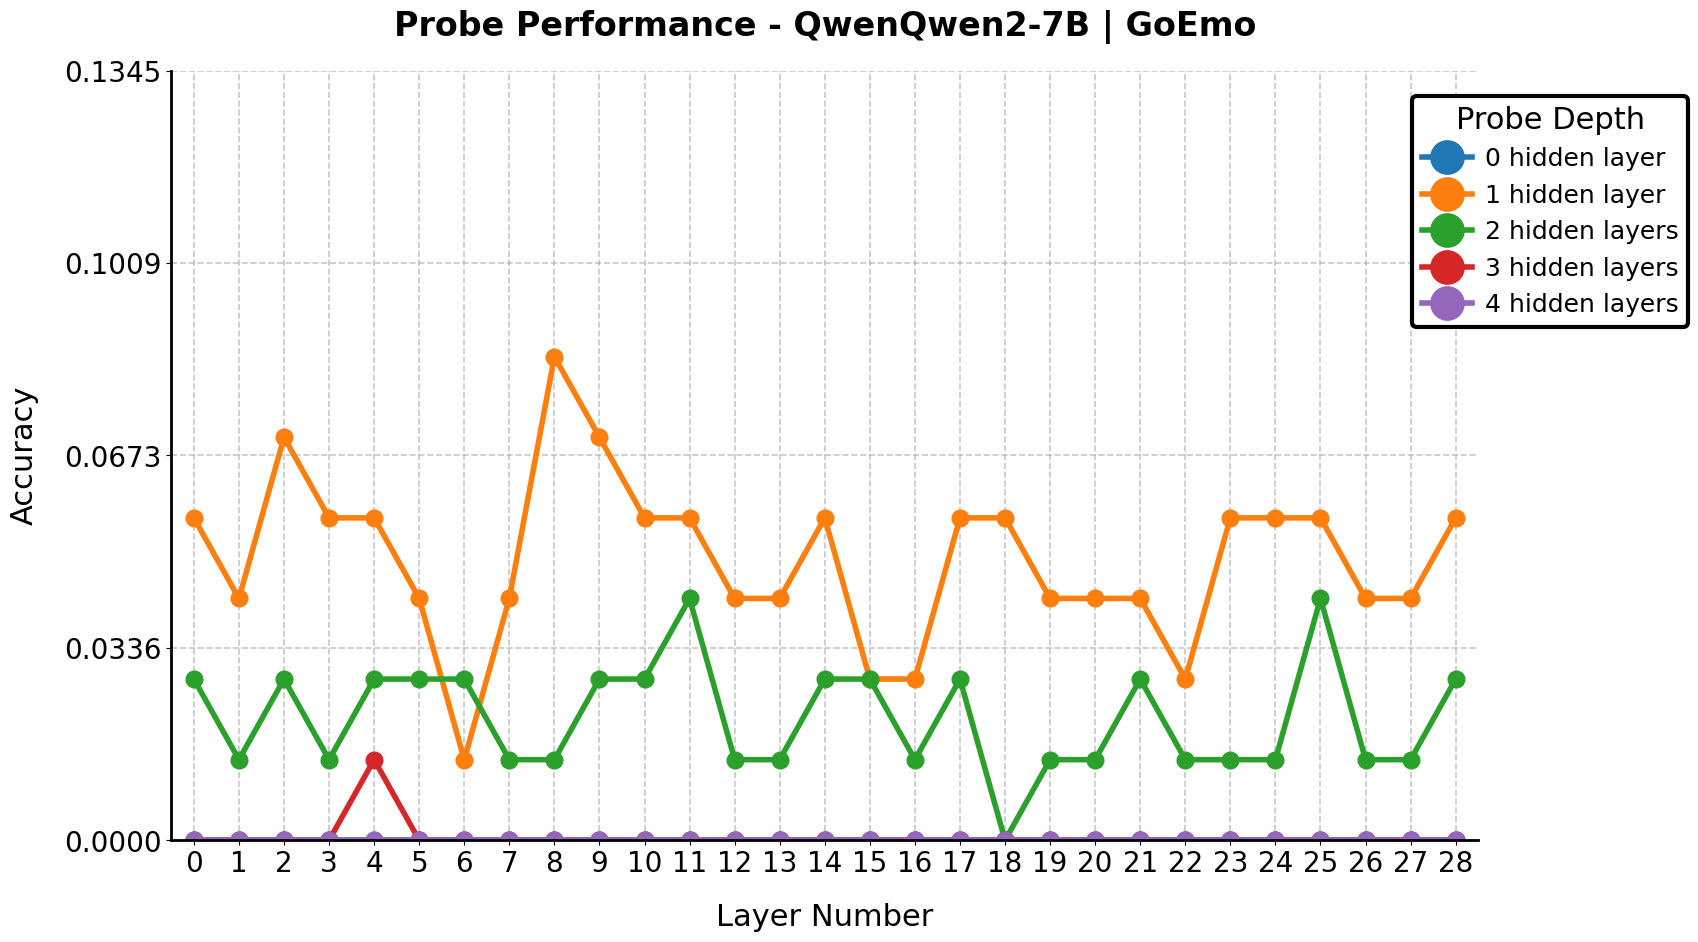

No valid data for QwenQwen2-7B | ISEAR, skipping.


In [14]:
# ====================================================
# Plotting Results
# ====================================================
def plot_results(results_dict):
    for model_ds, res in results_dict.items():
        layers_dict = {}
        all_depths = set()
        all_acc = []  # To collect all accuracy values
        
        # First pass to collect data and metrics
        for key, metrics in res.items():
            try:
                parts = key.split('_')
                if len(parts) < 3:
                    continue
                layer_num = int(parts[1])
                depth = int(parts[2].replace('HL',''))
                all_depths.add(depth)
                
                if layer_num not in layers_dict:
                    layers_dict[layer_num] = {}
                
                acc_value = metrics['acc']
                layers_dict[layer_num][depth] = acc_value
                all_acc.append(acc_value)
                
            except Exception as e:
                print(f"Skipping key {key}: {e}")
                continue
        
        if not all_acc:
            print(f"No valid data for {model_ds}, skipping.")
            continue
        
        # Calculate y-axis limits with padding
        min_acc = min(all_acc)
        max_acc = max(all_acc)
        padding = 0.05
        y_min = max(0, min_acc - padding)
        y_max = min(1, max_acc + padding)
        
        ordered_layers = sorted(layers_dict.keys())
        ordered_depths = sorted(all_depths)
        x = np.array(ordered_layers)
        
        # Configure plot aesthetics
        plt.figure(figsize=(20, 12))  # Increased vertical size
        plt.rcParams.update({
            'font.size': 20,
            'axes.titlesize': 24,
            'axes.labelsize': 22,
            'xtick.labelsize': 20,
            'ytick.labelsize': 20,
            'legend.fontsize': 18,
            'legend.title_fontsize': 22
        })
        
        # Plot each depth series
        for depth in ordered_depths:
            y_vals = []
            for layer in ordered_layers:
                y_vals.append(layers_dict[layer].get(depth, np.nan))
            plt.plot(x, y_vals, marker='o', markersize=12, linewidth=4,
                     label=f"{depth} hidden layer{'s' if depth > 1 else ''}")

        # Styling and labels
        plt.title(f"Probe Performance - {model_ds}", pad=25, fontweight='bold')
        plt.xlabel("Layer Number", labelpad=18)
        plt.ylabel("Accuracy", labelpad=18)
        
        # Axis configuration
        plt.xticks(x, fontsize=20)
        plt.yticks(np.linspace(y_min, y_max, 5), fontsize=20)  # Ensure 5 ticks
        plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.2)
        
        # Enhanced legend
        legend = plt.legend(title="Probe Depth", 
                          loc='upper right',
                          bbox_to_anchor=(1.18, 1),  # More space for text
                          markerscale=2,  # Larger legend markers
                          handletextpad=0.5,  # Space between marker and text
                          framealpha=1,
                          edgecolor='black',
                          borderaxespad=1)
        legend.get_frame().set_linewidth(3)  # Thicker border
        
        # Axis limits and styling
        plt.ylim(y_min, y_max)
        plt.xlim(min(x)-0.5, max(x)+0.5)
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['left'].set_linewidth(2)
        plt.gca().spines['bottom'].set_linewidth(2)
        
        # Final layout adjustments
        plt.tight_layout(pad=5)
        plt.show()

plot_results(all_results)

### If we had to guess QWEN model is closer to gpt-2 rather than bert that is it specializes more twoards generating rather than understanding ?

### the above is true, and this tends to repeat in decoder only models, which means encoder-only models are better at detecting emotions ? 

In [15]:
def plot_metric_progression(results_dict):
    """Plot multiple metrics across layers with statistical validation"""
    for model_ds, res in results_dict.items():
        metrics = {
            'acc': {'values': [], 'deltas': []},
            'hamming': {'values': [], 'deltas': []}
        }
        
        # Get all unique layers from keys (safer approach)
        layers = sorted({
            int(key.split('_')[1]) 
            for key in res.keys() 
            if key.startswith('layer_')
        })
        
        # Aggregate metrics (handle missing keys)
        for layer in layers:
            layer_acc = []
            layer_hamming = []
            
            for key in res:
                if key.startswith(f'layer_{layer}_'):
                    layer_acc.append(res[key]['acc'])
                    if 'hamming' in res[key]:
                        layer_hamming.append(res[key]['hamming'])
            
            if layer_acc:
                metrics['acc']['values'].append(np.mean(layer_acc))
            if layer_hamming:
                metrics['hamming']['values'].append(np.mean(layer_hamming))
            
        # Calculate deltas
        for metric in metrics:
            metrics[metric]['deltas'] = np.diff(metrics[metric]['values'])
            
        # Plotting
        fig, axs = plt.subplots(2, 2, figsize=(18, 12))
        
        # Accuracy progression
        axs[0,0].plot(layers, metrics['acc']['values'], 'o-')
        axs[0,0].set_title(f"Accuracy Progression - {model_ds}")
        axs[0,0].set_ylim(0, 1)
        
        # Hamming loss progression
        axs[0,1].plot(layers, metrics['hamming']['values'], 'o-')
        axs[0,1].set_title(f"Hamming Loss Progression - {model_ds}")
        
        # Delta plots
        axs[1,0].bar(layers[1:], metrics['acc']['deltas'])
        axs[1,0].axhline(0, color='grey', linestyle='--')
        axs[1,0].set_title("Accuracy Deltas Between Layers")
        
        axs[1,1].bar(layers[1:], metrics['hamming']['deltas'])
        axs[1,1].axhline(0, color='grey', linestyle='--')
        axs[1,1].set_title("Hamming Loss Deltas")
        
        plt.tight_layout()
        plt.show()

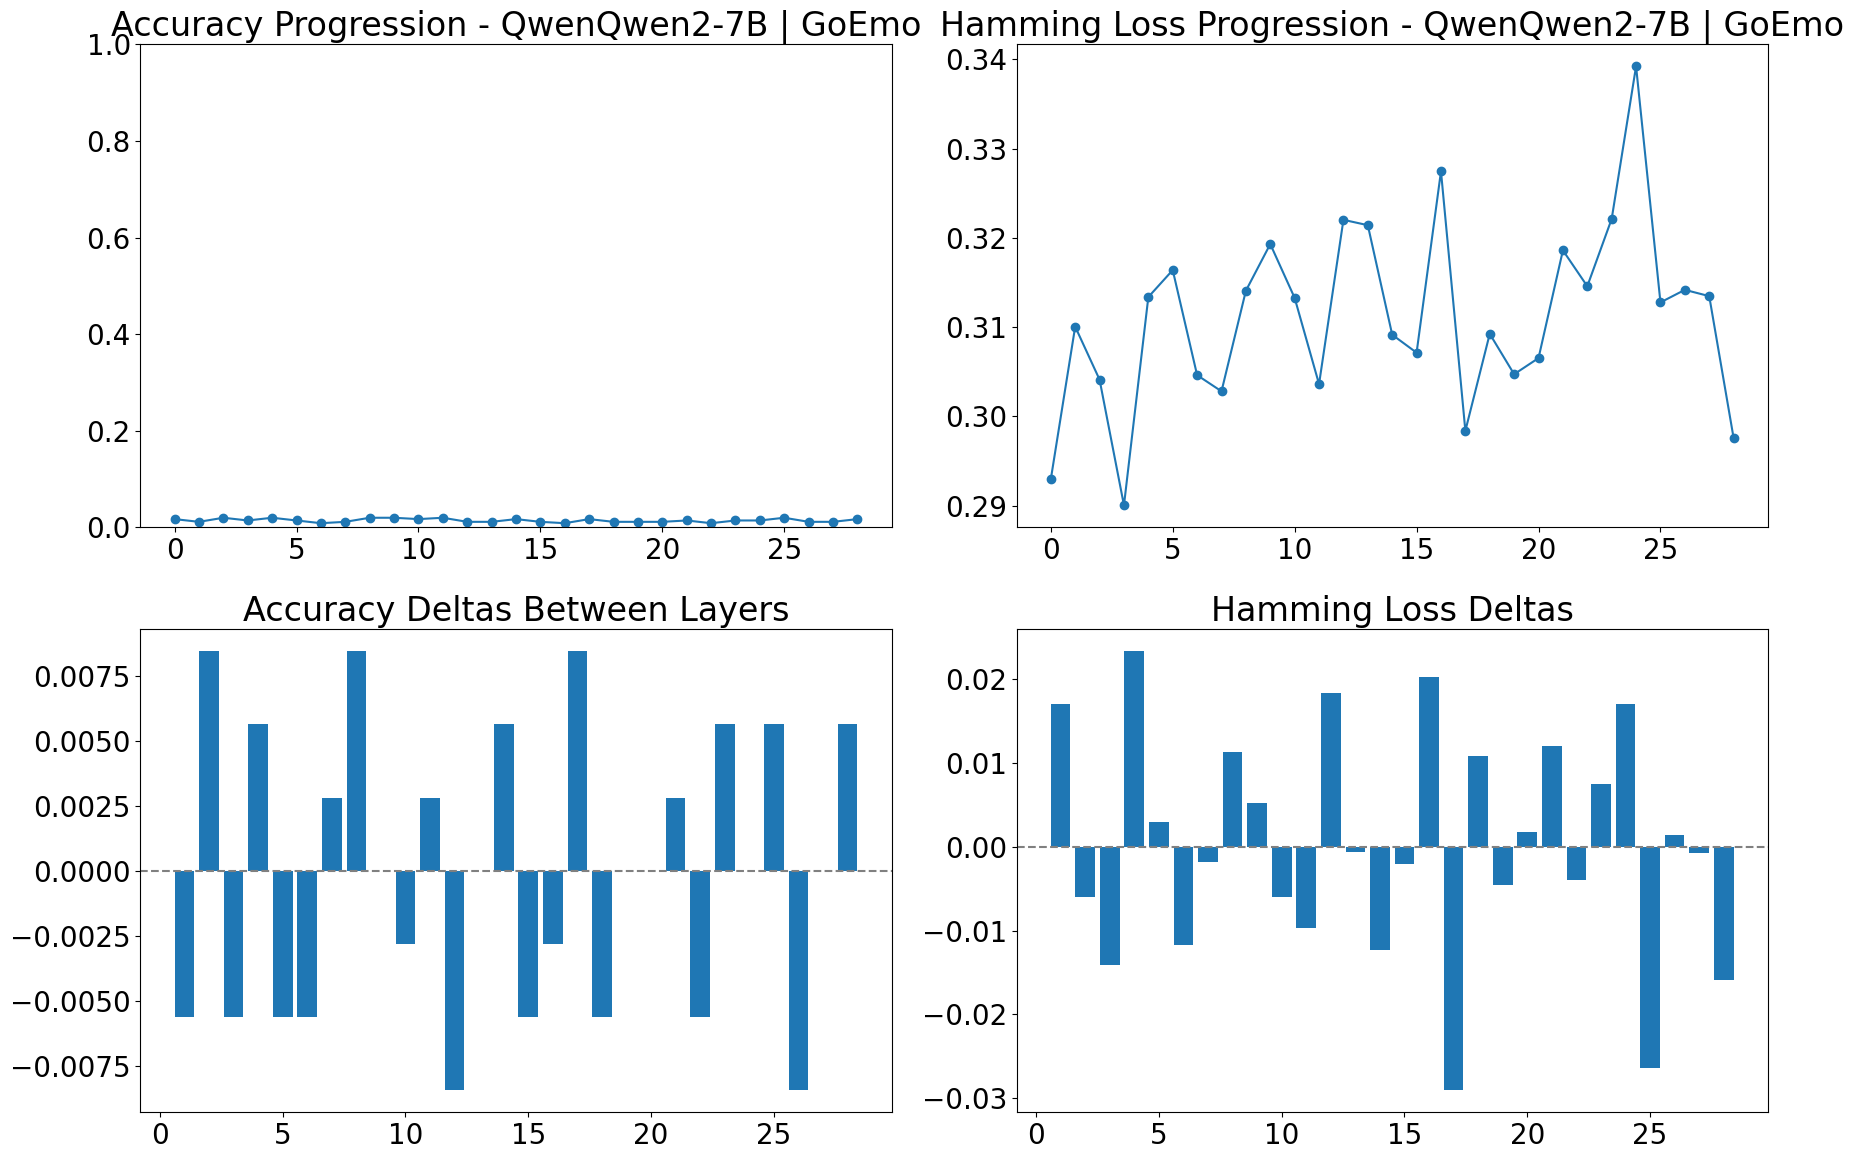

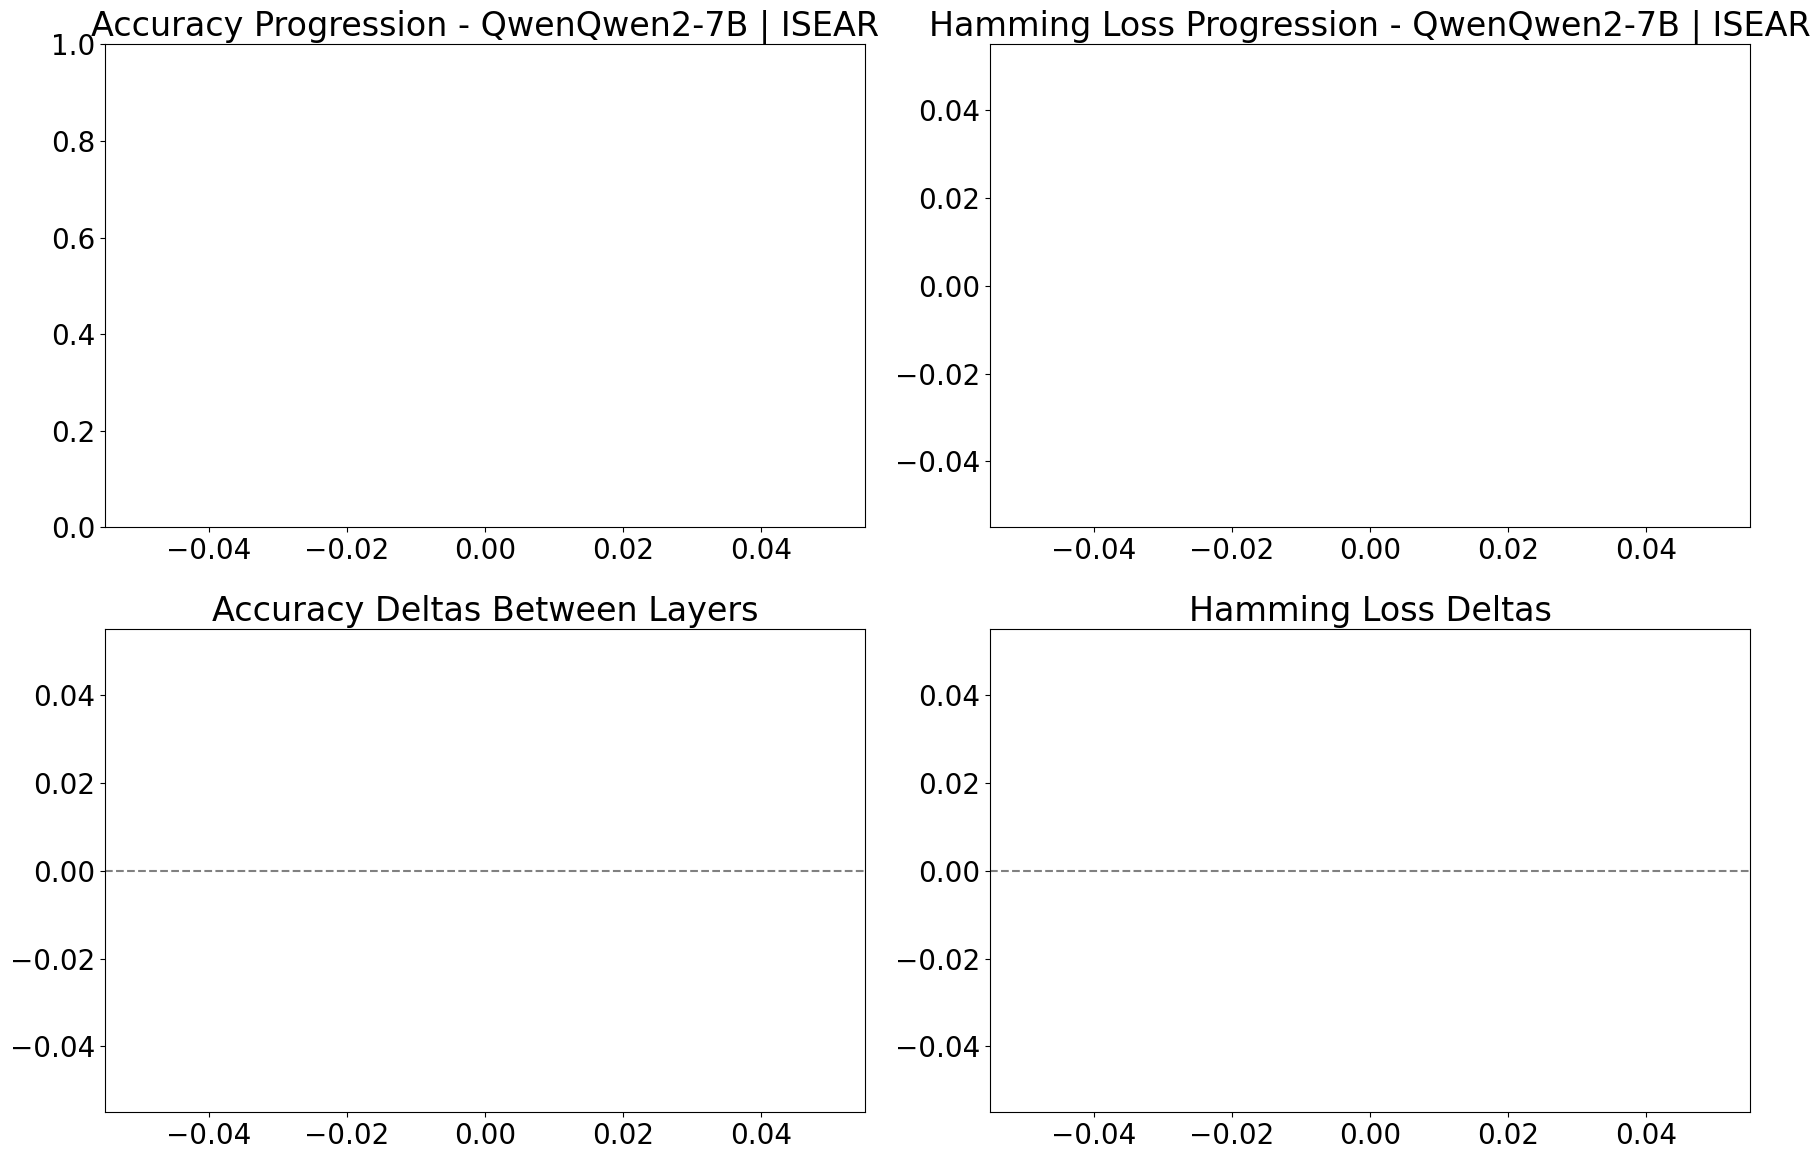

In [16]:
plot_metric_progression(all_results)

In [17]:
import seaborn as sns
def plot_emotion_heatmap(results_dict, emotion_labels):
    """Heatmap of emotion-class performance across layers"""
    for model_ds, res in results_dict.items():
        # Get first probe depth data
        layer_keys = [k for k in res.keys() if '_0HL' in k and 'per_class_f1' in res[k]]
        if not layer_keys:
            print(f"No per-class F1 data found for {model_ds}")
            continue
            
        layers = sorted(set(int(k.split('_')[1]) for k in layer_keys))
        
        # Initialize matrix: layers x emotions
        heatmap_data = np.zeros((len(layers), len(emotion_labels)))
        
        # Populate with per-class F1 scores
        for i, layer in enumerate(layers):
            key = f'layer_{layer}_0HL'
            if key in res:
                heatmap_data[i] = res[key]['per_class_f1']
        
        # Plot only if we have valid data
        if np.any(heatmap_data):
            plt.figure(figsize=(20, 12))
            sns.heatmap(
                heatmap_data.T,
                xticklabels=layers,
                yticklabels=emotion_labels,
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                vmin=0,
                vmax=1  # Fixed scale for better comparison
            )
            plt.title(f"Emotion-Class Performance by Layer - {model_ds}", pad=20)
            plt.xlabel("Layer Number", labelpad=15)
            plt.ylabel("Emotion Class", labelpad=15)
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid data to plot for {model_ds}")

In [18]:
EMOTION_LABELS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

plot_emotion_heatmap(all_results, emotion_labels=EMOTION_LABELS)

No per-class F1 data found for QwenQwen2-7B | GoEmo
No per-class F1 data found for QwenQwen2-7B | ISEAR


In [21]:
from scipy.stats import ttest_rel

def plot_significance_bars(results_dict):
    """Bar plot with significance markers between adjacent layers"""
    for model_ds, res in results_dict.items():
        layers = sorted(int(k.split('_')[1]) for k in res.keys() if '_0HL' in k)
        p_values = []
        
        # Pairwise t-tests
        for i in range(len(layers)-1):
            layer_a = [res[f'layer_{layers[i]}_{d}HL']['acc'] for d in range(5)]
            layer_b = [res[f'layer_{layers[i+1]}_{d}HL']['acc'] for d in range(5)]
            _, p = ttest_rel(layer_a, layer_b)
            p_values.append(p)
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(p_values)), -np.log10(p_values))
        plt.axhline(-np.log10(0.05), color='red', linestyle='--')
        plt.xticks(range(len(p_values)), [f"{layers[i]}-{layers[i+1]}" for i in range(len(p_values))])
        plt.ylabel("-log10(p-value)")
        plt.title(f"Layer Transition Significance - {model_ds}")
        plt.show()

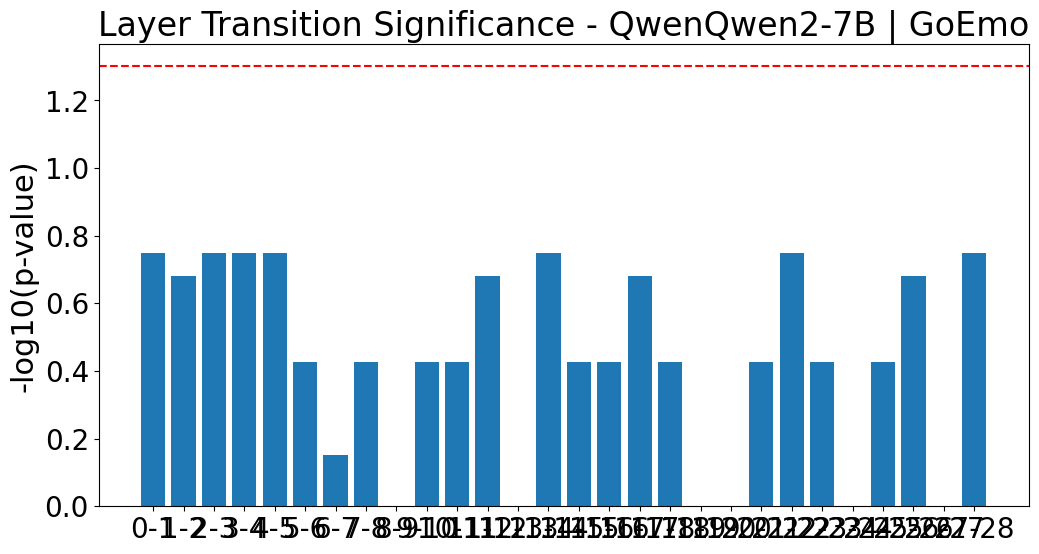

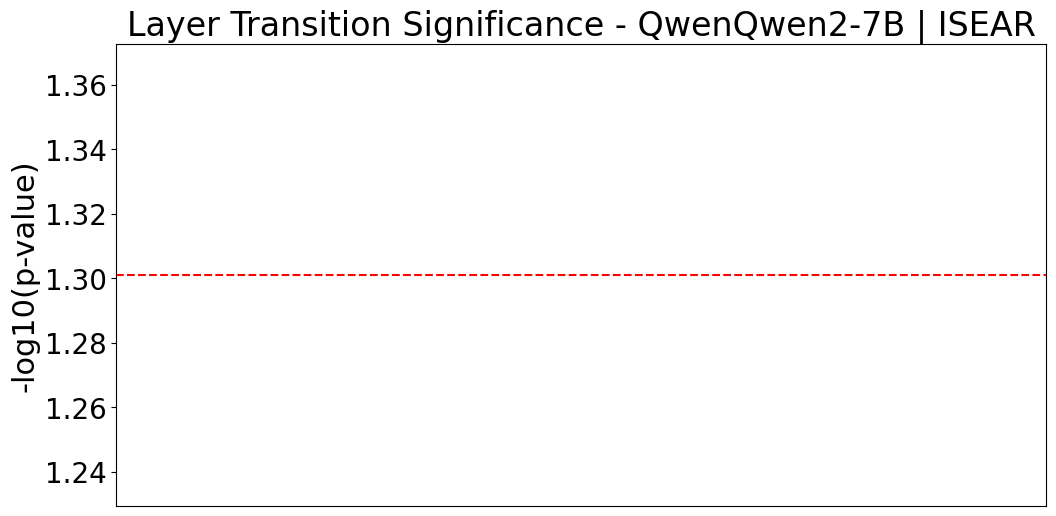

In [22]:
plot_significance_bars(all_results)

In [ ]:
def plot_depth_analysis(results_dict):
    """Compare probe architectures across layers"""
    for model_ds, res in results_dict.items():
        depths = sorted(set(int(k.split('_')[2].replace('HL','')) for k in res.keys()))
        avg_scores = {d: [] for d in depths}
        
        layers = sorted(set(int(k.split('_')[1]) for k in res.keys()))
        
        # Aggregate scores
        for layer in layers:
            for d in depths:
                scores = [res[f'layer_{layer}_{d}HL']['acc'] for _ in range(5)]  # Assume 5 runs
                avg_scores[d].append(np.mean(scores))
        
        # Plot
        plt.figure(figsize=(12, 6))
        for d in depths:
            plt.plot(layers, avg_scores[d], 'o-', label=f"{d} hidden layers")
        
        plt.title(f"Probe Depth Comparison - {model_ds}")
        plt.xlabel("Layer Number")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.ylim(0, 1)
        plt.grid(True)
        plt.show()

In [ ]:
plot_depth_analysis(all_results)